In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [ ]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:

file_path = 'data_input_auto/中国独立炼厂汽油表需.xlsx'
file_path1 = 'data_output_auto/中国主营成品油销售公司汽油库存预测结果.xlsx'
file_path2 = 'data_output_auto/中国汽油社会库存预测结果.xlsx'
file_path3 = 'data_output_auto/中国汽油实际消费量预测结果.xlsx'

# Read the Excel sheets
sheet = pd.ExcelFile(file_path).parse('Sheet1')
sheet1 = pd.ExcelFile(file_path1).parse('Sheet1')
sheet2 = pd.ExcelFile(file_path2).parse('Sheet1')
sheet3 = pd.ExcelFile(file_path3).parse('Sheet1')

# Rename 'DataTime' column to 'Date'
for df in [sheet, sheet1, sheet2, sheet3]:
    df.rename(columns={'DataTime': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 将sheet的日期设为索引
sheet.set_index('Date', inplace=True)
# 重采样为工作日频率(B)并进行线性插值
sheet = sheet.resample('B').asfreq()
sheet = sheet.interpolate(method='linear')
# 重置索引,使Date重新成为列
sheet.reset_index(inplace=True)

# Merge additional data into the original sheet
sheet_combined = sheet.copy()
sheet_combined = pd.merge(sheet_combined, sheet1, on='Date', how='outer', suffixes=('', '_new1'))
sheet_combined = pd.merge(sheet_combined, sheet2, on='Date', how='outer', suffixes=('', '_new2'))
sheet_combined = pd.merge(sheet_combined, sheet3, on='Date', how='outer', suffixes=('', '_new3'))

sheet_combined = sheet_combined[sheet_combined['Date'] >= '2024-01-01']

# 合并原始列和新列的数据
# 对于每一对列,使用原始列的数据,如果有缺失值则用新列的数据填充
sheet_combined['中国主营成品油销售公司汽油库存'] = sheet_combined['中国主营成品油销售公司汽油库存'].combine_first(sheet_combined['中国主营成品油销售公司汽油库存_new1'])
sheet_combined['中国汽油社会库存'] = sheet_combined['中国汽油社会库存'].combine_first(sheet_combined['中国汽油社会库存_new2']) 
sheet_combined['中国汽油实际消费量'] = sheet_combined['中国汽油实际消费量'].combine_first(sheet_combined['中国汽油实际消费量_new3'])

# 删除不再需要的新列
sheet_combined.drop(['中国主营成品油销售公司汽油库存_new1', '中国汽油社会库存_new2', '中国汽油实际消费量_new3'], axis=1, inplace=True)




In [4]:
sheet_combined.columns

Index(['Date', '中国独立炼厂汽油表需', '中国主营成品油销售公司汽油库存', '中国汽油社会库存', '中国汽油实际消费量'], dtype='object')

In [5]:
sheet_combined

,Date,中国独立炼厂汽油表需,中国主营成品油销售公司汽油库存,中国汽油社会库存,中国汽油实际消费量
1191,2024-01-01,101.914,760.036000,499.964000,305.262400
1192,2024-01-02,99.478,753.332000,500.528000,314.036800
1193,2024-01-03,97.042,746.628000,501.092000,322.811200
1194,2024-01-04,94.606,739.924000,501.656000,331.585600
1195,2024-01-05,92.170,733.220000,502.220000,340.360000
...,...,...,...,...,...
1566,2025-05-26,NaN,627.928406,423.604401,273.247620
1567,2025-05-27,NaN,629.531738,423.604401,273.122894
1568,2025-05-28,NaN,629.398804,423.604401,273.320099
1569,2025-05-29,NaN,633.000183,423.604401,273.908630


In [6]:
sheet_combined = sheet_combined[sheet_combined['Date'] >= '2023-01-01']
last_day = sheet_combined['Date'][sheet_combined['中国独立炼厂汽油表需'].last_valid_index()]
sheet_combined = sheet_combined[
    (sheet_combined['Date'] > last_day) | 
    (sheet_combined['中国独立炼厂汽油表需'].notna())
]
fill_methods = {
    '中国主营成品油销售公司汽油库存': 'interpolate',
    '中国汽油社会库存': 'interpolate',
    '中国汽油实际消费量':'interpolate'
} 

sheet_daily = fill_missing_values(sheet_combined, fill_methods, return_only_filled=False)

In [7]:
sheet_daily

,Date,中国独立炼厂汽油表需,中国主营成品油销售公司汽油库存,中国汽油社会库存,中国汽油实际消费量
1191,2024-01-01,101.914,760.036000,499.964000,305.262400
1192,2024-01-02,99.478,753.332000,500.528000,314.036800
1193,2024-01-03,97.042,746.628000,501.092000,322.811200
1194,2024-01-04,94.606,739.924000,501.656000,331.585600
1195,2024-01-05,92.170,733.220000,502.220000,340.360000
...,...,...,...,...,...
1566,2025-05-26,NaN,627.928406,423.604401,273.247620
1567,2025-05-27,NaN,629.531738,423.604401,273.122894
1568,2025-05-28,NaN,629.398804,423.604401,273.320099
1569,2025-05-29,NaN,633.000183,423.604401,273.908630


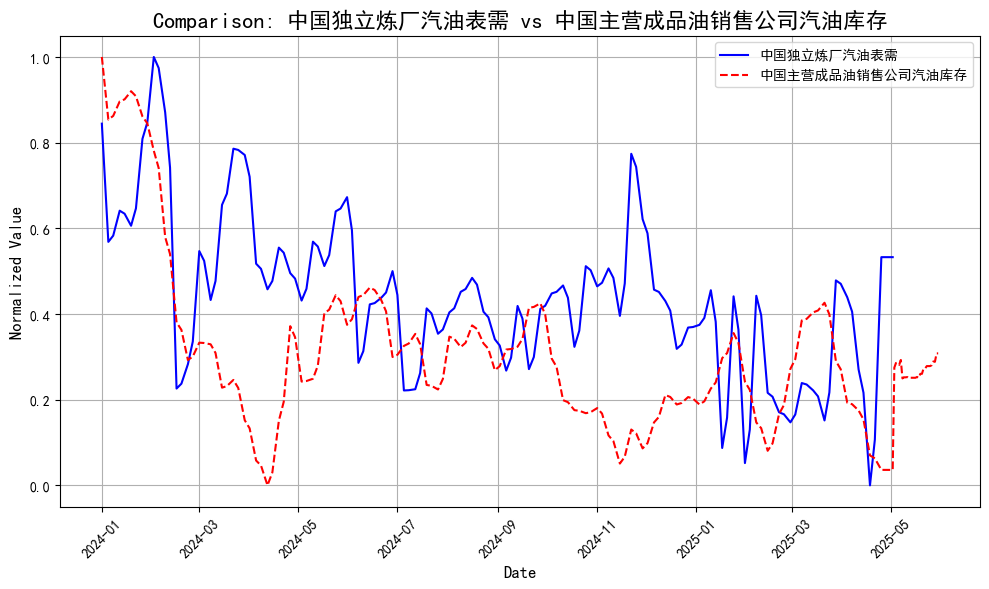

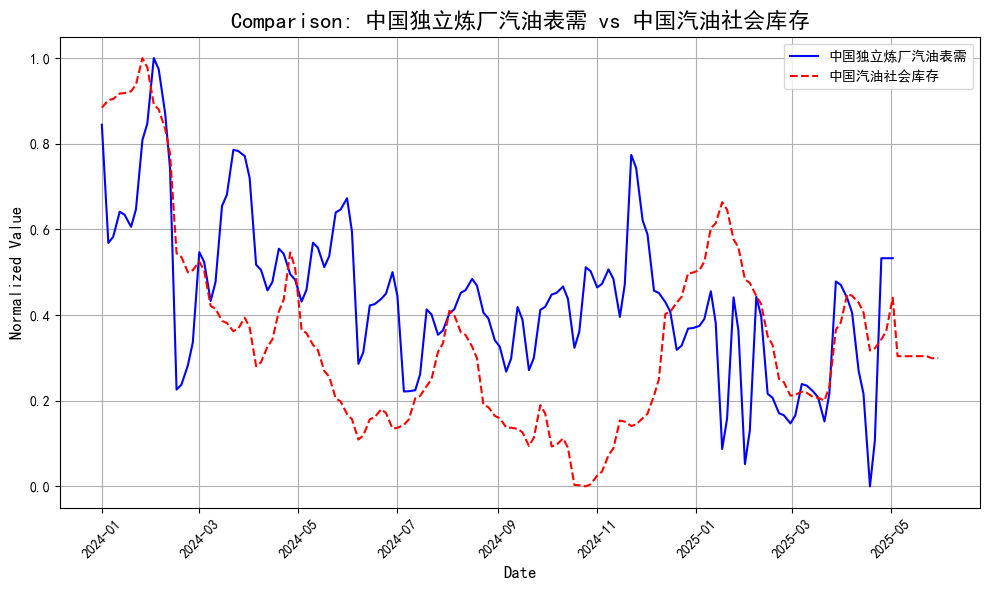

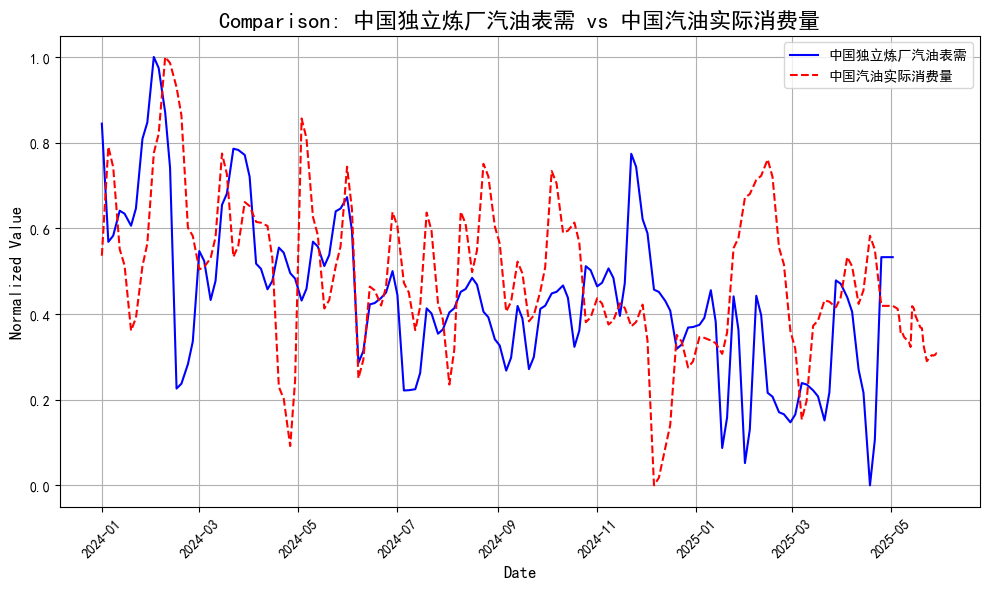

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='中国独立炼厂汽油表需', 
    compare_cols=['中国主营成品油销售公司汽油库存', '中国汽油社会库存', '中国汽油实际消费量']
)

In [9]:
# 划分训练集、测试集和未来数据
train_data = sheet_daily[sheet_daily['Date'] <= last_day]
test_period = 1
test_data = train_data[-test_period:]  
train_data = train_data[:-test_period]  
future_data = sheet_daily[sheet_daily['Date'] > last_day]

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[['中国主营成品油销售公司汽油库存', 
                      '中国汽油社会库存', 
                      '中国汽油实际消费量']]
y_train = train_data['中国独立炼厂汽油表需']
X_test = test_data[['中国主营成品油销售公司汽油库存', '中国汽油社会库存', '中国汽油实际消费量']]
y_test = test_data['中国独立炼厂汽油表需']

X_future = future_data[['中国主营成品油销售公司汽油库存', '中国汽油社会库存', '中国汽油实际消费量']]

In [10]:
# 初始化 MinMaxScaler
scaler = MinMaxScaler()

# 归一化特征数据
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 定义并训练 XGBRegressor 模型
xgb = XGBRegressor(objective='reg:squarederror', 
                   n_estimators=300, 
                   learning_rate=0.05, 
                   max_depth=5, 
                   subsample=0.9, 
                   colsample_bytree=0.8)
xgb.fit(X_train_scaled, y_train)


# 训练集和测试集的预测
y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

# 计算 MSE 和 R^2 分数
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse}, Train R^2: {train_r2}")
print(f"Test MSE: {test_mse}, Test R^2: {test_r2}")

# 未来预测

X_all = sheet_daily[sheet_daily['Date'] <= last_day][['中国主营成品油销售公司汽油库存', '中国汽油社会库存', '中国汽油实际消费量']]
y_all = sheet_daily[sheet_daily['Date'] <= last_day]['中国独立炼厂汽油表需']

# 归一化所有历史特征数据
X_all_scaled = scaler.fit_transform(X_all)

# 使用所有历史数据重新训练模型
xgb.fit(X_all_scaled, y_all)


y_future_pred = xgb.predict(X_future_scaled)

test_data = test_data.copy()
future_data = future_data.copy()

test_data.loc[:, '预测值'] = y_test_pred
future_data.loc[:, '预测值'] = y_future_pred

Train MSE: 0.37801381951044316, Train R^2: 0.9902133287688997
Test MSE: 0.01521858951486563, Test R^2: nan


C:\Users\wxqp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


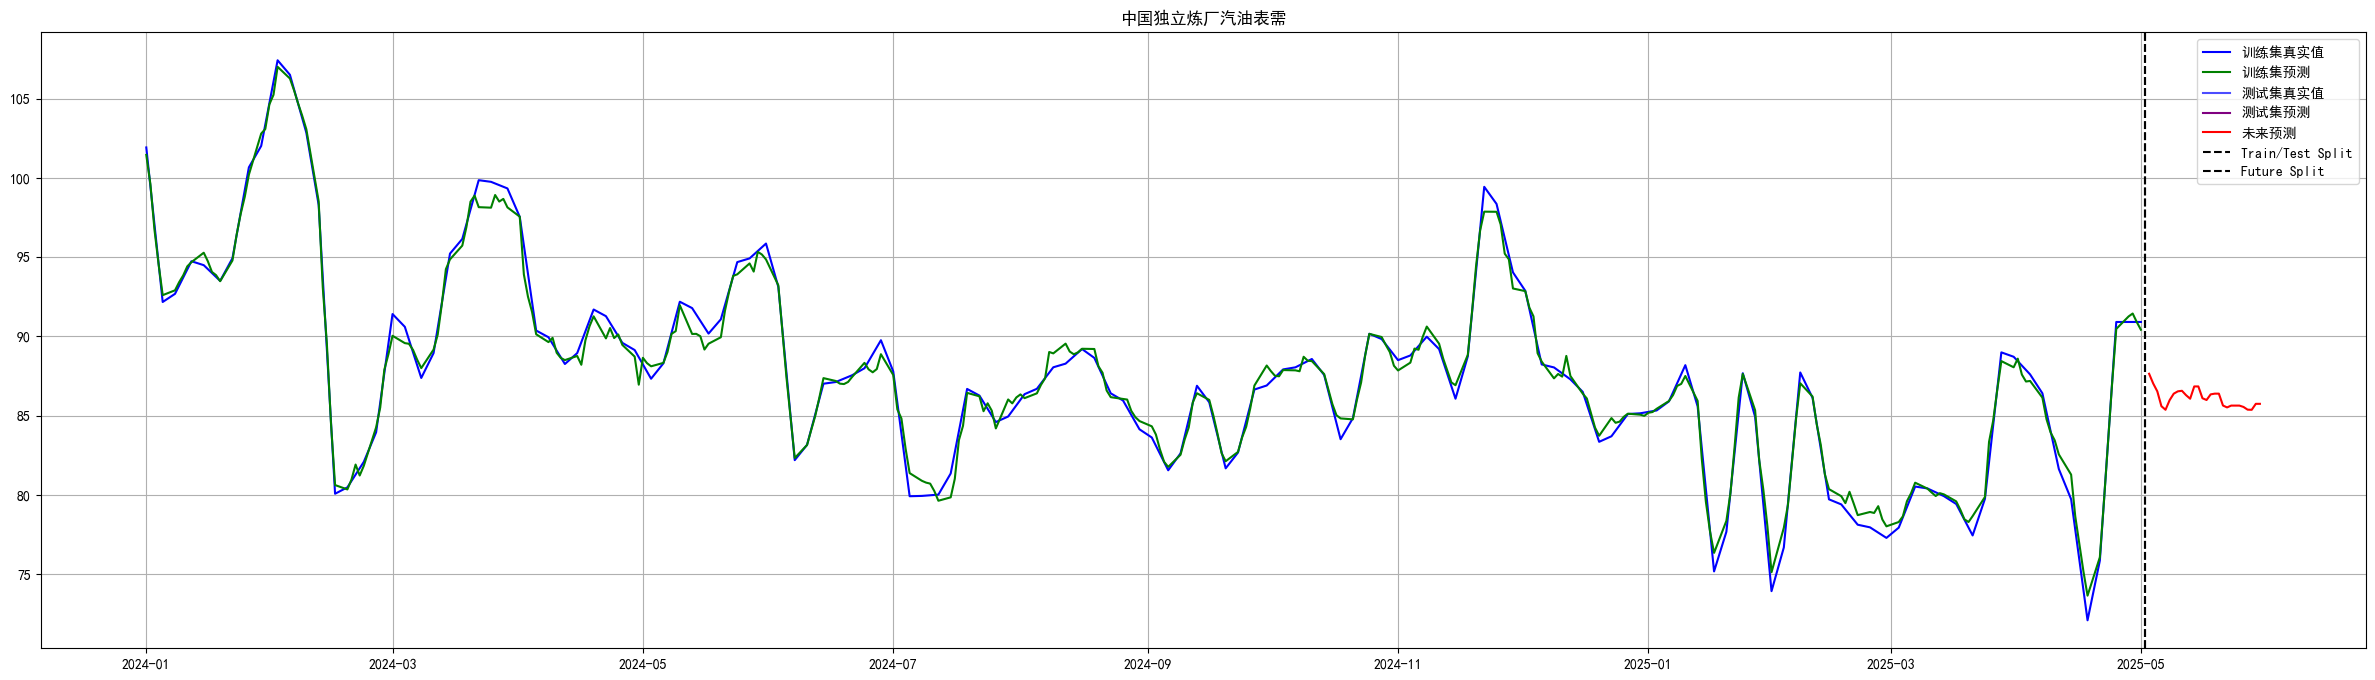

In [11]:
# 可视化
plt.figure(figsize=(30, 8))

plt.plot(train_data['Date'], y_train, label='训练集真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred, label='训练集预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集真实值', color='blue',alpha=0.7)
plt.plot(test_data['Date'], test_data['预测值'], label='测试集预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')

plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')
plt.title('中国独立炼厂汽油表需')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
future_predictions = future_data[['Date', '预测值']].copy()
future_predictions.columns = ['Date', '中国独立炼厂汽油表需']

future_predictions.to_excel('data_output_auto/中国独立炼厂汽油表需.xlsx', index=False)
future_predictions.head()

,Date,中国独立炼厂汽油表需
1543,2025-05-03,87.645912
1544,2025-05-04,87.030319
1545,2025-05-05,86.534142
1546,2025-05-06,85.599167
1547,2025-05-07,85.374474


---


In [13]:
# 任务1: 合并训练集、测试集真实值和未来预测
# 获取2023年以后的训练集数据
train_data_2023 = train_data[train_data['Date'].dt.year >= 2023][['Date', '中国独立炼厂汽油表需']]
test_actual = test_data[['Date', '中国独立炼厂汽油表需']]

# 合并训练集和测试集的真实值
historical_actual = pd.concat([train_data_2023, test_actual])
historical_actual.columns = ['Date', '实际值']

# 获取未来预测值
future_pred = future_data[['Date', '预测值']]  # 修改这里的列名
future_pred.columns = ['Date', '预测值']

# 合并所有数据
merged_df = pd.merge(historical_actual, future_pred, on='Date', how='outer')
merged_df = merged_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y/%m/%d')

# 保存到Excel
merged_df.to_excel('eta/独立炼厂表需_合并数据.xlsx', index=False,float_format='%.2f')
merged_df

,Date,实际值,预测值
377,2025/05/30,NaN,85.749008
376,2025/05/29,NaN,85.749008
375,2025/05/28,NaN,85.372482
374,2025/05/27,NaN,85.381416
373,2025/05/26,NaN,85.552650
...,...,...,...
4,2024/01/05,92.170,NaN
3,2024/01/04,94.606,NaN
2,2024/01/03,97.042,NaN
1,2024/01/02,99.478,NaN


In [14]:
# 任务2: 生成月度数据
# 获取2023年以后的实际值
actual_values = pd.concat([
    train_data[train_data['Date'].dt.year >= 2023][['Date', '中国独立炼厂汽油表需']],
    test_data[['Date', '中国独立炼厂汽油表需']]
])
actual_values.columns = ['Date', '实际值']

# 创建包含2024年及以后训练集预测值的DataFrame
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred[train_data['Date'].dt.year >= 2024]
})

# 重新构建predictions DataFrame
predictions = pd.concat([
    train_pred_2024,
    test_data[['Date', '预测值']],
    future_data[['Date', '预测值']]
], ignore_index=True)

# 重新合并实际值和预测值
monthly_df = pd.merge(actual_values, predictions, on='Date', how='outer')

# 转换为月度数据
monthly_df['Date'] = pd.to_datetime(monthly_df['Date'])
monthly_df.set_index('Date', inplace=True)
monthly_df = monthly_df.resample('ME').mean()
monthly_df.reset_index(inplace=True)
monthly_df = monthly_df.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y/%m/%d')

# 保存月度数据
monthly_df.to_excel('eta/独立炼厂表需_月度数据.xlsx', index=False,float_format= '%.2f')
monthly_df.head()

,Date,实际值,预测值
17,2025/06/30,NaN,85.561241
16,2025/05/31,90.910000,86.400932
15,2025/04/30,83.703718,83.970467
14,2025/03/31,80.945895,81.107384
13,2025/02/28,80.383320,80.912834
12,2025/01/31,82.764423,82.943954


---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "汽油独立炼厂表需"

# 调用函数更新数据
success = update_excel_data(merged_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "汽油独立炼厂表需"
# 调用函数更新数据
success = update_excel_data(monthly_df, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/04/30)
数据已成功更新到Excel文件
